In [1]:
import numpy as np 
import pandas as pd

In [2]:
# Comment out when running in kaggle

# INDEX = 'usedCarSkuId'
# TARGET = 'listed_price'
# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
# df = pd.read_csv('/kaggle/input/transformed-data/transformed.csv', index_col=INDEX)

In [3]:
# While running locally
from src.utils.data_loader import DataLoader
from src.feature_engineering.feature_transformations import FeatureEngineeringTransformations
from src.utils.constants import *
import os
from src.model_selection.load_data import load_train_test_valid_data

train, test, valid = load_train_test_valid_data(
	train_path='../data/train/train_2023-04-06_14-02-36.csv',
	test_path='../data/test/test_2023-04-06_14-02-38.csv',
	validation_path='../data/validation/validation_2023-04-06_14-02-39.csv',
)
train.shape, test.shape, valid.shape


Reading training file from : ../data/train/train_2023-04-06_14-02-36.csv
<class 'pandas.core.frame.DataFrame'>
Index: 28808 entries, eaa36396-cd6c-4a4e-9f85-57669077d9a0 to be462430-1815-43b9-9f15-11c5a024bd22
Data columns (total 49 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   myear                 28808 non-null  int64  
 1   body                  28792 non-null  object 
 2   transmission          28808 non-null  object 
 3   fuel                  28808 non-null  object 
 4   km_driven             28808 non-null  int64  
 5   ip                    28808 non-null  int64  
 6   oem                   28808 non-null  object 
 7   model                 28808 non-null  object 
 8   variant               28808 non-null  object 
 9   City                  28808 non-null  object 
 10  listed_price          28808 non-null  float64
 11  utype                 28808 non-null  object 
 12  top_features          28808 non-null  

((28808, 49), (5084, 49), (3766, 49))

---

# Feature Engineering

*Only required when running this notebook in kaggle or without the repository*

In [4]:
# from sklearn.base import BaseEstimator
# from ast import literal_eval
#
#
# class FeatureEngineeringTransformations(BaseEstimator):
#     """
#     This class contains all the recommended feature engineering transformations for the dataset.
#
#     :parameter
#         df: pd.DataFrame
#             The dataframe to be transformed
#         object_cols: list
#             The list of columns that contain the car features like top_features, comfort_features, etc. that need to be transformed
#     """
#
#     def __init__(
#             self,
#             df: pd.DataFrame,
#             object_cols=None
#     ):
#         if object_cols is None:
#             object_cols = [
#                 'top_features',
#                 'comfort_features',
#                 'interior_features',
#                 'exterior_features',
#                 'safety_features'
#             ]
#         self.df = df.copy()
#         self.object_cols = object_cols
#         self.feature_prices = None
#         self.is_fitted = False
#
#     def _car_object_feature_dict(self) -> dict:
#         unique_feature_scores = dict()
#         for col in self.object_cols:
#             for _, row in self.df.iterrows():
#                 feature_list = literal_eval(row[col])
#                 for feature in feature_list:
#                     if feature in unique_feature_scores.keys():
#                         unique_feature_scores[feature][1] += 1
#                         unique_feature_scores[feature][0] += row[TARGET]
#                     else:
#                         unique_feature_scores[feature] = [row[TARGET], 1]
#
#         return unique_feature_scores
#
#     def _map_object_cols_to_scores(self, x: str) -> float:
#         feature_list = literal_eval(x)
#         feature_score = 0
#         for feature in feature_list:
#             if feature in self.feature_prices.keys():
#                 feature_score += self.feature_prices[feature][0] / self.feature_prices[feature][1]
#             else:
#                 feature_score += 0
#         return feature_score
#
#     def _car_object_feature_transformation(self, df) -> pd.DataFrame:
#         if self.feature_prices is None:
#             raise Exception('Please fit the transformer first')
#
#         for col in self.object_cols:
#             df[f'{col}_score'] = df[col].apply(self._map_object_cols_to_scores)
#             df.drop(col, axis=1, inplace=True)
#             # Replace zero scores with nan
#             df[f'{col}_score'] = df[f'{col}_score'].replace(0, np.nan)
#         return df
#
#     def fit(self, X=None, y=None):
#         self.feature_prices = self._car_object_feature_dict()
#         self.df = self._car_object_feature_transformation(self.df)
#         self.is_fitted = True
#         return self
#
#     def transform(self, df: pd.DataFrame) -> pd.DataFrame:
#         if not self.is_fitted:
#             raise Exception('Please fit the transformer first')
#
#         df = df.copy()
#         # Transform the object columns to scores
#         df = self._car_object_feature_transformation(df)
#         return df

---

# Training and Testing Data

In [5]:
# from src.model_selection.load_data import load_train_test_valid_data
# train, test, valid = load_train_test_valid_data(
#     train_path='../data/train/train_2023-04-06_14-02-36.csv',
#     test_path='../data/test/test_2023-04-06_14-02-38.csv',
#     valid_path='../data/validation/validation_2023-04-06_14-02-39.csv',
# )
train.shape, test.shape, valid.shape


((28808, 49), (5084, 49), (3766, 49))

In [6]:
X_train = train.drop(columns=[TARGET], axis=1).reset_index(drop=True)
y_train = train[TARGET].reset_index(drop=True)
X_test = test.drop(columns=[TARGET], axis=1).reset_index(drop=True)
y_test = test[TARGET].reset_index(drop=True)

---

# Pre Processor

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn import set_config
from sklearn.experimental import enable_iterative_imputer
from src.feature_engineering.imputations import CustomMatchingImputer, MatchingImputerArguments
from sklearn.impute import KNNImputer

## Feature Engineering

In [29]:
feature_engineering = FeatureEngineeringTransformations(target=TARGET)
replace_col_scores = feature_engineering.object_cols
replacement_col_scores = [f'{col}_score' for col in replace_col_scores]

## Feature Scaling and encoding

In [51]:
from sklearn.preprocessing import OneHotEncoder

categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_cols = [col for col in categorical_cols if col not in replace_col_scores]
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols.extend(replacement_col_scores)
one_hot_cols = [col for col in categorical_cols if X_train[col].nunique() < 50]

num_match_imp_args = MatchingImputerArguments(
	strategy = 'mean',
    columns = ['model', 'variant'],
    add_indicator = True,
    match_level = 0
)

numerical_transformer = Pipeline([
	# ('match_imputer', CustomMatchingImputer(TARGET, num_match_imp_args)),
    ('imputer', KNNImputer(n_neighbors=5)),
	('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
	('imputer', SimpleImputer(strategy='most_frequent', fill_value='missing')),
    ('one_hot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

column_transformer = ColumnTransformer([
	('num', numerical_transformer, numerical_cols),
	('cat', categorical_transformer, categorical_cols)
])

In [52]:
preprocessor = Pipeline([
	('feature_engineering', feature_engineering),
	('column_transformer', column_transformer),
])

---

# Model

In [77]:
from sklearn.linear_model import Lasso
# Implement ElasticNet
from sklearn.linear_model import ElasticNet
from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(
    regressor=Lasso(alpha=0.0001, random_state=42, max_iter=10000),
)

pipeline = Pipeline([
	('preprocessor', preprocessor),
	('model', model)
])

In [ ]:
from sklearn.model_selection import cross_val_score

# cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
pipeline.fit(X_train, y_train)

In [74]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
# Make predictions on the test data
y_pred = pipeline.predict(X_test)

# Calculate the MAPE and MAE
mape = mean_absolute_percentage_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"MAPE: {mape}")
print(f"MAE: {mae}")

In [73]:
residuals = abs(y_test-y_pred)
residuals_percent = residuals/y_test
residuals_percent.describe()

In [57]:
print(f'25% of the residuals are less than {residuals_percent.quantile(0.25)}')
print(f'50% of the residuals are less than {residuals_percent.quantile(0.5)}')
print(f'75% of the residuals are less than {residuals_percent.quantile(0.75)}')
print(f'90% of the residuals are less than {residuals_percent.quantile(0.9)}')
print(f'95% of the residuals are less than {residuals_percent.quantile(0.95)}')
print(f'99% of the residuals are less than {residuals_percent.quantile(0.99)}')

25% of the residuals are less than 0.0766245102836136
50% of the residuals are less than 0.1629965035025142
75% of the residuals are less than 0.2979158701365643
90% of the residuals are less than 0.498270589937528
95% of the residuals are less than 0.7142448207832034
99% of the residuals are less than 1.1996418846762251


In [59]:
print(f'25% of the prices are less than {y_train.quantile(0.25)}')
print(f'50% of the prices are less than {y_train.quantile(0.5)}')
print(f'75% of the prices are less than {y_train.quantile(0.75)}')
print(f'90% of the prices are less than {y_train.quantile(0.9)}')
print(f'95% of the prices are less than {y_train.quantile(0.95)}')
print(f'99% of the prices are less than {y_train.quantile(0.99)}')

25% of the prices are less than 320000.0
50% of the prices are less than 525000.0
75% of the prices are less than 860000.0
90% of the prices are less than 1550000.0
95% of the prices are less than 2150000.0
99% of the prices are less than 4850000.0


Text(0, 0.5, 'Error percentage')

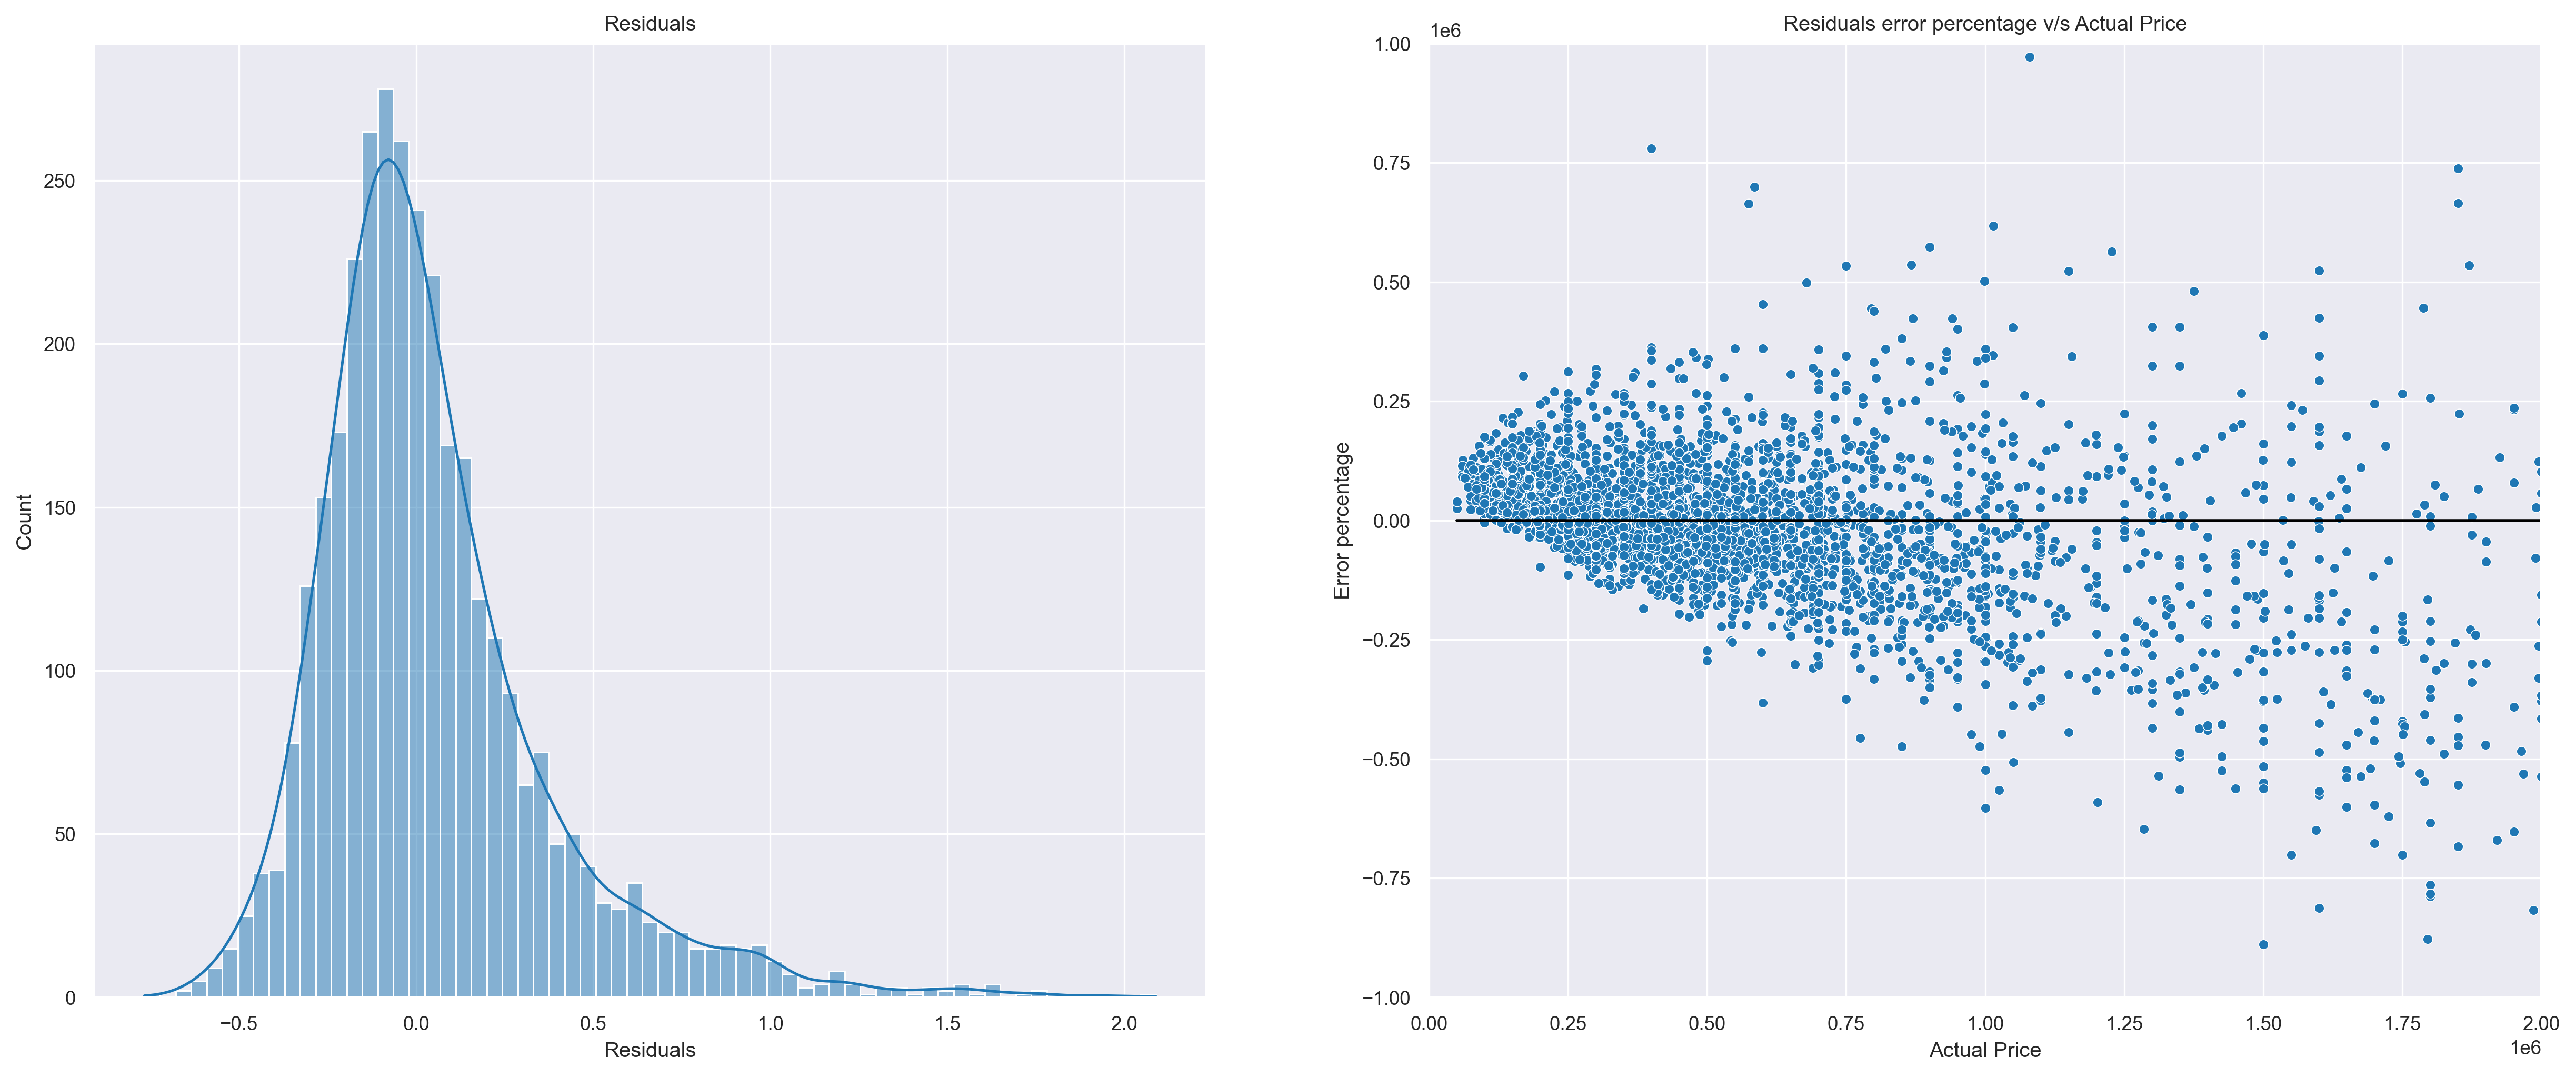

In [66]:
from matplotlib import pyplot as plt
import seaborn as sns
import random

pallete = sns.light_palette("navy", reverse=True, n_colors=10)
color1 = random.choice(pallete)
color2 = random.choice(pallete)

sns.set_style('darkgrid')
sns.set_context('paper', font_scale=1)
plt.rcParams['figure.dpi'] = 300
fig, ax = plt.subplots(1, 2, figsize=(20, 8))


# Plot the residuals in a histogram in subplot 1
plot1 = sns.histplot(x=(y_pred-y_test)/y_test, kde=True, ax=ax[0])
ax[0].set_title('Residuals')
ax[0].set_xlabel('Residuals')
ax[0].set_ylabel('Count')


# Plot the residual along the index in a reg plot in subplot 2
plot2 = sns.scatterplot(x=y_test, y=(y_pred-y_test), s=20)
sns.lineplot(x=y_test, y=0, ax=ax[1], color='black')
plot2.set_xlim([0, 2e6])
plot2.set_ylim([-1e6, 1e6])

ax[1].set_title('Residuals error percentage v/s Actual Price')
ax[1].set_xlabel('Actual Price')
ax[1].set_ylabel('Error percentage')

---

# Hyperparamter Optimization usin Optuna HyperBand

In [ ]:
import optuna
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold

def objective(trial, pipeline, X, y):
    param_grid = {
        "tree_method": "hist", # change to gpu_hist if a gpu is available
        "objective": "reg:squarederror",
        "single_precision_histogram": True,
        "importance_type": "gain",
        "n_estimators": trial.suggest_categorical("n_estimators", [1000, 2000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "max_depth": trial.suggest_categorical("max_depth", [5,7,9,11,13,15,17]),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 300),
        "subsample": trial.suggest_float("subsample", 0.1, 1),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1),
        "reg_lambda": trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
        "reg_alpha": trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
        "random_state": 42,
    }
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        pipeline['model'].set_params(
            n_jobs= -1,
            **param_grid
        )
        pipeline.fit(X_train, y_train)

        preds = pipeline.predict(X_test)
        cv_scores[idx] = mean_absolute_percentage_error(y_test, preds)

    return np.mean(cv_scores)

In [ ]:
# Define the XGBoost model
xgb_model = xgboost.XGBRegressor()

# Define the full pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', xgb_model)
])

# Define the Optuna search algorithm
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(lambda trial: objective(trial, pipeline, X_train, y_train), n_trials=50, timeout=None)

In [ ]:
trial = study.best_trial
best_params = trial.params

best_xgbmodel = xgboost.XGBRegressor(
    **best_params, 
    random_state=42, 
    n_jobs=-1, 
    tree_method="hist", 
    objective="reg:squarederror", 
    single_precision_histogram=True,
    importance_type="gain"
)

# Define the full pipeline
best_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', best_xgbmodel)
])

best_pipeline.fit(X_train, y_train)

In [ ]:
# Make predictions on the test data
y_pred = best_pipeline.predict(X_test)

# Calculate the MAPE and MAE
mape = mean_absolute_percentage_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"MAPE: {mape}")
print(f"MAE: {mae}")